# Diamond Price Estimator
## Introduzione e Obiettivi
- Obiettivo del progetto: creare una pipeline di Machine Learning per prevedere il prezzo dei diamanti basandosi sulle loro caratteristiche fisiche.
- Tipo di problema: regressione
- Metriche di successo: minimizzare l'errore (RMSE, MAE) e massimizzare la qualita' (R^2).

## Descrizione del dataset
- Link al dataset: https://www.kaggle.com/datasets/swatikhedekar/price-prediction-of-diamond
- Dimensioni 53940 righe, 11 colonne
- Features: 
    - Numeriche: carat, depth, table, x, y, z
    - Categoriche: cut, color, clarity
- Target: price 



# 1. Setup and data loading

In [6]:
import sys
import sklearn
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

# Plot settings
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data
diamonds = pd.read_csv("diamonds.csv")

if "Unnamed: 0" in diamonds.columns:
    diamonds = diamonds.drop("Unnamed: 0", axis=1)

print(diamonds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


In [7]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Correlazioni tra features

In [8]:
diamonds.corr(numeric_only=True)['price'].sort_values(ascending=False)

price    1.000000
carat    0.921591
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth   -0.010647
Name: price, dtype: float64

# 2. Preprocessing

## 2.1 Cleaning

1) Rimozione valori nulli: vengono eliminate le osservazioni che presentano valori pari a 0 per le dimensioni lunghezza, larghezza o profondità. 
2) Feature Engineering (Sperimentale): Il codice include logiche (attualmente commentate) per semplificare il dataset: creazione di una feature sintetica volume per aggregare le tre dimensioni e ridurre la multicollinearità.

In [9]:
print("Invalid dimensions (x, y, or z == 0):")

print(diamonds[(diamonds['x'] == 0) | (diamonds['y'] == 0) | (diamonds['z'] == 0)].shape)

diamonds = diamonds[(diamonds[['x', 'y', 'z']] != 0).all(axis=1)]
    
# diamonds['volume'] = diamonds['x'] * diamonds['y'] * diamonds['z']

# # Vediamo come correla il volume col prezzo
# print("Correlazione Volume-Prezzo:", diamonds['volume'].corr(diamonds['price']))

# diamonds = diamonds.drop(['x', 'y', 'z'], axis=1)

Invalid dimensions (x, y, or z == 0):
(20, 10)


## 2.2 Encoding Categorical Variables
Le variabili cut (taglio), color (colore) e clarity (purezza) sono di tipo categorico ordinale. Esse presentano dunque un ordine gerarchico intrinseco (es. "Ideal" è superiore a "Fair", il colore "D" è migliore di "J").

Applichiamo quindi un Ordinal Encoding Manuale. Assegniamo un valore numerico crescente in base alla qualità del diamante.


In [10]:
cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

diamonds['cut_enc'] = diamonds['cut'].map(cut_mapping)
diamonds['color_enc'] = diamonds['color'].map(color_mapping)
diamonds['clarity_enc'] = diamonds['clarity'].map(clarity_mapping)

diamonds_prepared = diamonds.drop(['cut', 'color', 'clarity'], axis=1)

In [11]:
diamonds_prepared.head()

,carat,depth,table,price,x,y,z,cut_enc,color_enc,clarity_enc
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4,5,1
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3,5,2
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,5,4
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3,1,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,1


## 2.3 Train-Test Split
Partizione:
- 80% Train
- 20% Test

In [12]:
from sklearn.model_selection import train_test_split

X = diamonds_prepared.drop("price", axis=1)
y = diamonds_prepared["price"]

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (43136, 9)
Test shape: (10784, 9)


## 2.4 Scaling
Viene applicata la standardizzazione (StandardScaler) per portare tutte le feature numeriche sulla stessa scala.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Modeling

## 3.1 Lasso
Di seguito utilizziamo la regrezione Lasso per valutare l'importanza delle variabili. 

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

X = diamonds_prepared.drop("price", axis=1) 
y = diamonds_prepared["price"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 50 valori da 10^-4 (0.0001) a 10^4 (10000)
alphas_to_test = np.logspace(-4, 4, 50)

lasso = LassoCV(alphas=alphas_to_test,  cv=10) 
lasso.fit(X_scaled, y)

coeffs = pd.Series(lasso.coef_, index=X.columns)

print("--- Importanza delle Feature secondo Lasso ---")
print(coeffs.sort_values(key=abs, ascending=False))

print("\n--- Feature Inutili ---")
print(coeffs[coeffs == 0].index.tolist())

--- Importanza delle Feature secondo Lasso ---
carat          5167.637828
x             -1016.242360
clarity_enc     822.841454
color_enc       549.107226
cut_enc         134.117763
depth          -112.390325
z               -70.559134
table           -59.347007
y                52.770415
dtype: float64

--- Feature Inutili ---
[]


## 3.2 Ridge
Utilizziamo la regressione Ridge come primo approccio. Il valore di apha migliore viene scelto tramite Cross Validation.

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

alphas_to_test = np.logspace(-4, 4, 50) 

ridge_cv = RidgeCV(alphas=alphas_to_test, cv=10)

ridge_cv.fit(X_train_scaled, y_train)

print(f"Miglior alpha trovato: {ridge_cv.alpha_}")

y_pred_ridge = ridge_cv.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"RidgeCV RMSE: {rmse_ridge:.2f}")
print(f"RidgeCV R2: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"RidgeCV MAE:  {mae_ridge:.2f}")

Miglior alpha trovato: 159.98587196060572
RidgeCV RMSE: 1184.07
RidgeCV R2: 0.9125
RidgeCV MAE:  806.33


## 3.3 Random Forest

Dopo aver esplorato i modelli lineari, introduciamo un approccio non lineare basato su alberi decisionali: il **Random Forest Regressor**.

La Random Forest è un metodo di **Ensemble (Bagging)** che aggrega le predizioni di molteplici alberi decisionali indipendenti. Questo approccio è fondamentale per ridurre la varianza e mitigare il rischio di *overfitting* tipico dei singoli alberi decisionali, garantendo una maggiore robustezza su dati mai visti.

Per la configurazione del modello, adottiamo una strategia di ottimizzazione degli iperparametri basata su **Randomized Search** con Cross-Validation ($k=5$).
Rispetto alla *Grid Search* (che esplora esaustivamente tutte le combinazioni), la Randomized Search campiona un numero prefissato di configurazioni (`n_iter=10`) da distribuzioni statistiche definite. Questo permette di esplorare lo spazio dei parametri in modo efficiente, riducendo drasticamente il costo computazionale senza sacrificare significativamente le performance.

**Giustificazione degli Iperparametri analizzati:**
* **`n_estimators`**: Testiamo foreste con diverse dimensioni (50 e 100 alberi) per valutare il trade-off tra stabilità della predizione e tempo di training.
* **`max_depth`**: Limitiamo la profondità massima degli alberi per controllare la complessità del modello e prevenire l'overfitting locale.
* **`min_samples_split`**: Definisce il numero minimo di campioni necessari per dividere un nodo. Valori più alti (es. 5 o 10) agiscono come regolarizzatori, impedendo all'albero di isolare gruppi troppo piccoli di dati (rumore).
* **`max_features`**: Variamo il numero di feature considerate per ogni split (es. `sqrt`) per aumentare la "diversità" tra gli alberi (decorrelazione), punto di forza delle Random Forests.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter 
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': [1.0, 'sqrt'] 
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train) 

best_rf = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 1.0, 'max_depth': 20}


Utilizziamo ora il **Test Set** ($X_{test}$), che è stato isolato all'inizio del progetto e non è mai stato "visto" dal modello durante le fasi di training o di ottimizzazione degli iperparametri. Questo garantisce che le metriche ottenute siano una stima onesta delle performance del modello nel mondo reale.

**Metriche di Valutazione scelte:**
* **RMSE (Root Mean Squared Error):** La radice dell'errore quadratico medio. Penalizza maggiormente gli errori grandi (outlier) rispetto a quelli piccoli. È nella stessa unità di misura del target (prezzo).
* **MAE (Mean Absolute Error):** La media degli errori assoluti. È molto intuitivo: ci dice, in media, di quanto sbaglia il modello (in dollari/euro) su ogni predizione.
* **$R^2$ Score (Coefficiente di Determinazione):** Indica la proporzione della varianza della variabile target che è prevedibile dalle feature.
    * $R^2 = 1$: Modello perfetto.
    * $R^2 = 0$: Il modello predice semplicemente la media dei dati (baseline).

In [17]:
# Predictions with the best model
y_pred_rf = best_rf.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R^2 Score: {r2_rf:.4f}")



--- Random Forest Performance ---
RMSE: 513.73
MAE: 260.11
R^2 Score: 0.9835


### Analisi RandomForest

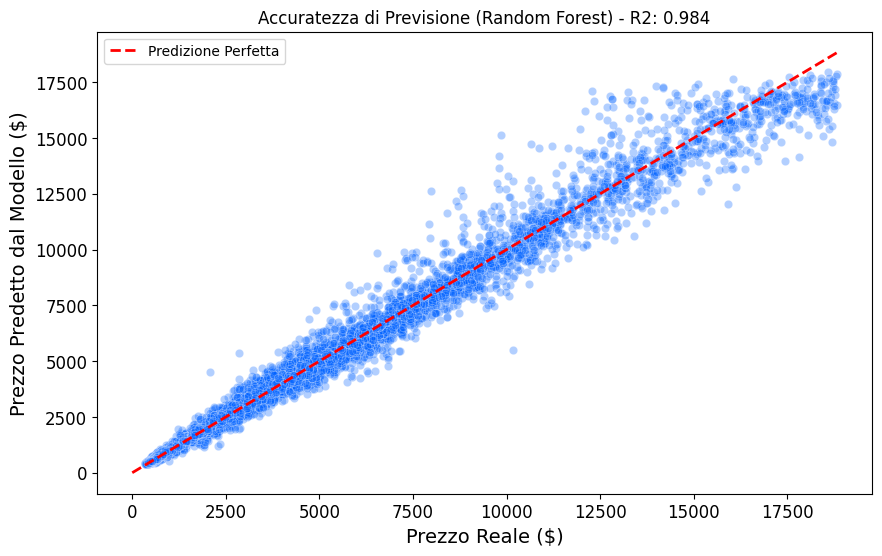

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color="#0062ff")

m = max(y_test.max(), y_pred_rf.max())
plt.plot([0, m], [0, m], 'r--', lw=2, label='Predizione Perfetta')

plt.title(f'Accuratezza di Previsione (Random Forest) - R2: {r2_score(y_test, y_pred_rf):.3f}')
plt.xlabel('Prezzo Reale ($)')
plt.ylabel('Prezzo Predetto dal Modello ($)')
plt.legend()
plt.show()

Analizzando i residui, notiamo una forma a 'imbuto'. L'errore assoluto è piccolo per i diamanti economici, ma cresce per quelli costosi. Questo suggerisce che il modello fatica a stimare i 'casi limite' di altissimo valore.

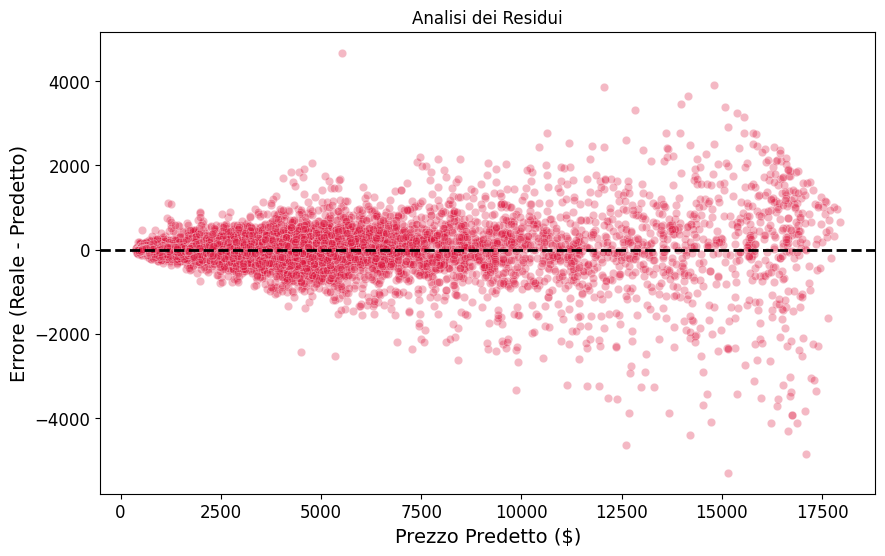

In [27]:

residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.3, color='crimson')
plt.axhline(y=0, color='black', linestyle='--', lw=2)

plt.title('Analisi dei Residui')
plt.xlabel('Prezzo Predetto ($)')
plt.ylabel('Errore (Reale - Predetto)')
plt.show()

La distribuzione degli errori è una gaussiana molto stretta centrata sullo zero. Ciò conferma che il modello non è 'biased' (non tende a sovrastimare o sottostimare sistematicamente), ma ha un errore casuale bilanciato.

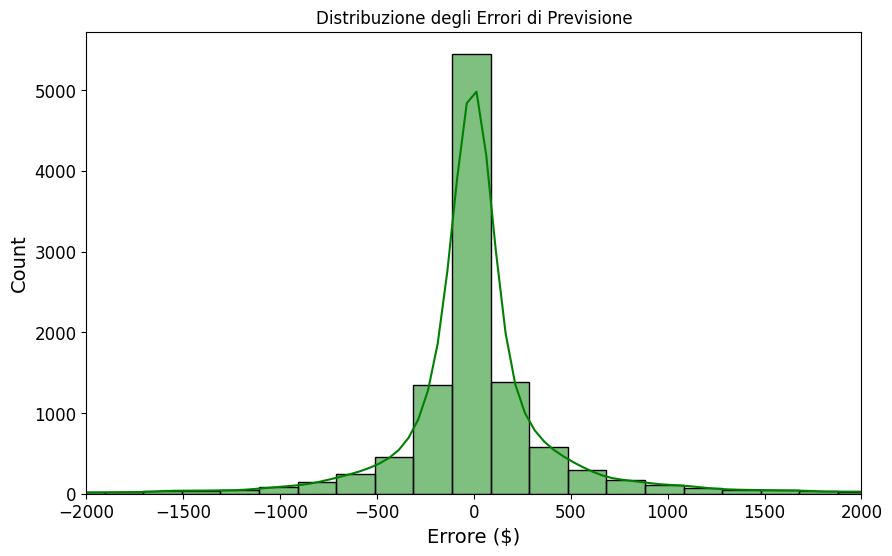

In [28]:

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='green')
plt.title('Distribuzione degli Errori di Previsione')
plt.xlabel('Errore ($)')
plt.xlim(-2000, 2000) 
plt.show()

## 3.4 VotingRegressor


Per tentare di migliorare ulteriormente le performance e, soprattutto, la robustezza del modello, implementiamo una tecnica di **Ensemble Learning**.

Mentre la Random Forest è un ensemble *omogeneo* (tanti alberi), qui utilizziamo un **Voting Regressor** per creare un ensemble *eterogeneo*. Combiniamo due "visioni" matematiche diverse dei dati:
1.  **Linear View (Ridge Regression):** Ottima per catturare trend globali e lineari, con bassa varianza.
2.  **Non-Linear View (Random Forest):** Ottima per catturare relazioni complesse e locali.

**Come funziona:**
Il `VotingRegressor` addestra entrambi i modelli sui dati e, per ogni predizione, calcola la **media** dei risultati dei singoli modelli. Questo approccio ("Saggezza della folla") spesso permette di compensare gli errori specifici di un singolo algoritmo.

In [18]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

voting_reg = VotingRegressor(
    estimators=[
        ('rf', best_rf),      # Usa il miglior RF trovato
        ('ridge', ridge_cv), 
    ]
)

print("Addestramento Voting Regressor in corso...")
voting_reg.fit(X_train_scaled, y_train) 

pred = voting_reg.predict(X_test_scaled)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("\n--- Perfomance Combinata ---")
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2) Score: {r2:.4f}') 

Addestramento Voting Regressor in corso...

--- Perfomance Combinata ---
Mean Absolute Error (MAE): 475.67
R-squared (R2) Score: 0.9663


## 3.5 Analisi dei risultati

**Osservazione dei Dati:**
Il **Voting Regressor** ha ottenuto un $R^2$ di **0.9640** e un MAE di **484.16**.
Confrontando questi risultati con i modelli singoli, notiamo un comportamento interessante:
* **Random Forest:** $R^2 \approx 0.982$ (Il migliore)
* **Voting Regressor:** $R^2 \approx 0.964$ (Intermedio)
* **Ridge Regression:** $R^2 \approx 0.914$ (Il "peggiore")

**Interpretazione Critica:**
In questo esperimento, l'applicazione dell'Ensemble Eterogeneo **non ha superato** le performance del miglior modello singolo (Random Forest). Perché?

Il Voting Regressor calcola la **media** delle predizioni dei modelli sottostanti. Poiché c'è un divario significativo di prestazioni tra la Random Forest (eccellente) e la Ridge Regression (buona, ma limitata dalla sua linearità), la Ridge ha agito come un fattore "diluente", abbassando leggermente la precisione complessiva rispetto alla sola Random Forest.

**Conclusioni:**
Sebbene l'Ensemble non abbia fornito il miglior punteggio assoluto, l'esperimento è scientificamente rilevante perché conferma che la relazione tra le feature dei diamanti e il prezzo è **fortemente non-lineare**.
L'introduzione di una componente lineare (Ridge) nell'equazione finale "sporca" la capacità della Random Forest di seguire le curve complesse dei dati. Pertanto, il **Random Forest (best_rf)** rimane il nostro modello migliore.

# 4. Visualizzazione - SHAP

Sebbene i modelli di insieme come la Random Forest offrano prestazioni predittive superiori rispetto ai modelli lineari, spesso vengono criticati per essere delle "Black Boxes" (scatole nere) difficili da interpretare.

Per ovviare a questo problema, utilizziamo la libreria **SHAP (SHapley Additive exPlanations)**.
SHAP si basa sulla Teoria dei Giochi per assegnare a ogni feature un valore che rappresenta il suo contributo (positivo o negativo) alla predizione finale rispetto alla media.

**Obiettivo del grafico (Summary Plot):**
Il grafico seguente ci permette di capire:
1.  **Importanza:** Quali variabili impattano di più sul prezzo (sono in alto nel grafico).
2.  **Direzione:** Come il valore di una feature influenza il prezzo.
    * I punti **rossi** indicano valori alti della feature.
    * I punti **blu** indicano valori bassi.
    * Se i punti rossi sono a destra (SHAP positivo), significa che un valore alto della feature fa aumentare il prezzo.

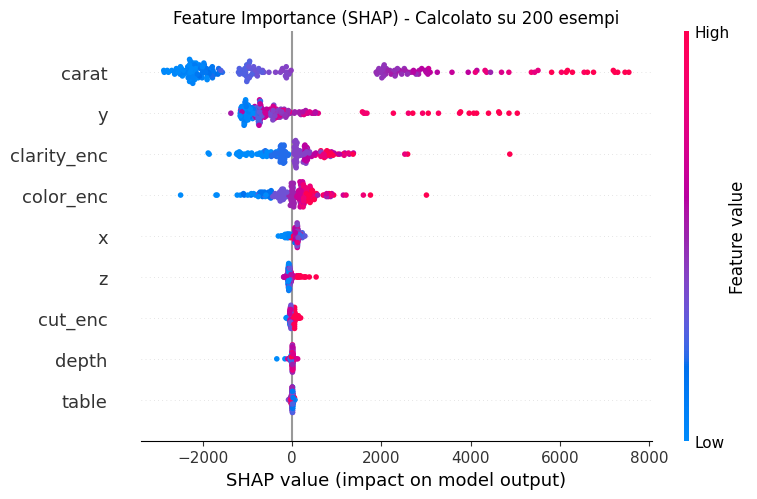

In [19]:
import shap
X_sample = X_test[:200]

feature_names = X_test.columns 
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer(X_sample_df)

plt.figure(figsize=(10, 8))
plt.title("Feature Importance (SHAP) - Calcolato su 200 esempi")
shap.summary_plot(shap_values, X_sample, show=False)
plt.show()

Oltre a capire il comportamento globale del modello, è spesso fondamentale giustificare una singola predizione ("Local Interpretability").
Per questo utilizziamo il **Waterfall Plot** di SHAP.

**Come leggere il grafico:**
* **$E[f(x)]$ (Base Value):** È il valore medio delle predizioni del modello (il prezzo medio che il modello si aspetta "alla cieca").
* **Barre Rosse (+):** Indicano le caratteristiche che hanno spinto il prezzo **verso l'alto** rispetto alla media.
* **Barre Blu (-):** Indicano le caratteristiche che hanno spinto il prezzo **verso il basso**.
* **$f(x)$ (Output):** Il valore finale predetto per questo specifico diamante.

Questo grafico visualizza matematicamente come la somma dei contributi delle singole feature porti esattamente dalla media generale alla predizione finale.

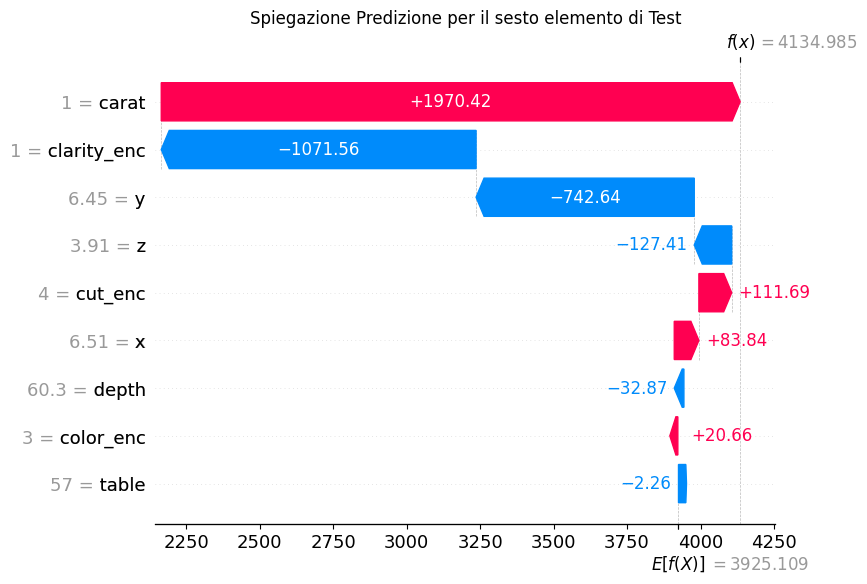

In [20]:
plt.figure()
plt.title("Spiegazione Predizione per il sesto elemento di Test")
shap.plots.waterfall(shap_values[5], show=False)
plt.show()

Infine, analizziamo nel dettaglio la relazione tra la feature più importante e il target.
Utilizziamo uno **Scatter Plot di dipendenza** che mostra:
* **Asse X:** Il valore della top features.
* **Asse Y:** Il valore SHAP (quanto quella feature ha alzato o abbassato il prezzo).
* **Colore:** Una seconda feature che interagisce con la prima (selezionata automaticamente da SHAP).

Questo grafico ci permette di rispondere a domande come: *"L'aumento del prezzo è lineare rispetto al carato o c'è una soglia oltre la quale il prezzo esplode?"*

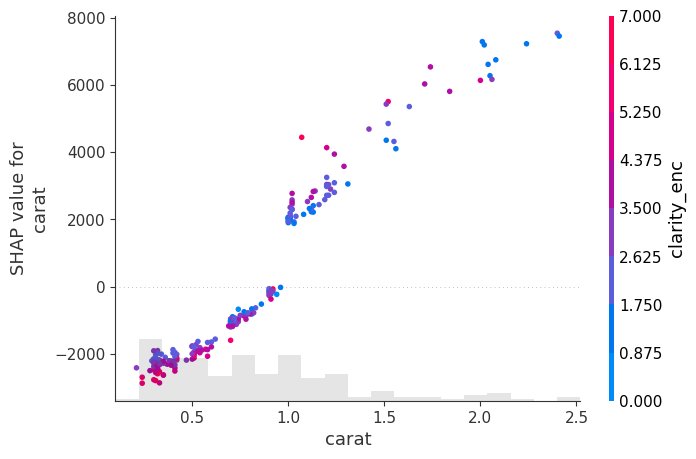

In [21]:
top_feature = shap_values.feature_names[0]
shap.plots.scatter(shap_values[:, top_feature], color=shap_values)

# 5. Pipeline

Per concludere, riorganizziamo l'intero flusso di lavoro utilizzando la classe **Pipeline** di Scikit-Learn.

Le Pipeline offrono vantaggi scientifici e ingegneristici fondamentali:
1.  **Prevenzione del Data Leakage:** Assicurano che le trasformazioni (es. Scaling) vengano "imparate" solo sul Training Set e applicate al Test Set, evitando contaminazioni.
2.  **Riproducibilità:** L'intero processo (Preprocessing + Model) è incapsulato in un unico oggetto, facile da salvare e riutilizzare.
3.  **Gestione Categoriale:** Utilizziamo `OrdinalEncoder` all'interno della pipeline per gestire le variabili ordinali (*Cut, Color, Clarity*) rispettando la loro gerarchia intrinseca.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Define features
numeric_cols = ['carat', 'table','x', 'y','z','depth'] 
categorical_cols = ['cut', 'color', 'clarity']

cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OrdinalEncoder(categories=[cut_order, color_order, clarity_order]), categorical_cols)
])


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42))
])

X_raw = diamonds.drop("price", axis=1) 
y_raw = diamonds["price"]
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

pipeline.fit(X_train_raw, y_train_raw)
print(f"Pipeline R2 Score (End-to-End): {pipeline.score(X_test_raw, y_test_raw):.4f}")

Pipeline R2 Score (End-to-End): 0.9835
